In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from scipy.stats import ttest_rel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from gensim.models import Word2Vec
import time

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

/Users/diwashsapkota/Desktop/project/paper/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/diwashsapkota/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diwashsapkota/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/diwashsapkota/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load the dataset
data = pd.read_csv('enrondataset.csv')

In [3]:
# Data Preprocessing
def preprocess_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
data['cleaned_text'] = data['text'].apply(preprocess_text)
data = data.dropna()
data = data[data['cleaned_text'].str.strip() != '']

In [4]:
# Feature Extraction: TF-IDF
tfidf = TfidfVectorizer(max_features=2000, stop_words='english')
X_tfidf = tfidf.fit_transform(data['cleaned_text'])

# Feature Extraction: Word2Vec
tokenized_text = data['cleaned_text'].apply(word_tokenize)
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=50, window=5, min_count=1, workers=4)
def get_w2v_features(text):
    tokens = word_tokenize(text)
    vectors = [w2v_model.wv[token] for token in tokens if token in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(50)
w2v_features = np.array([get_w2v_features(text) for text in data['cleaned_text']])

# Combine TF-IDF and Word2Vec features into a DataFrame
X_tfidf_dense = X_tfidf.toarray()
X_tfidf_dense = np.clip(X_tfidf_dense, a_min=0, a_max=1e6)
scaler = StandardScaler()
X_tfidf_scaled = scaler.fit_transform(X_tfidf_dense)

# Create column names for DataFrame
tfidf_columns = [f'tfidf_{i}' for i in range(2000)]
w2v_columns = [f'w2v_{i}' for i in range(50)]
all_columns = tfidf_columns + w2v_columns

# Combine features into a DataFrame
X_combined = pd.DataFrame(
    np.hstack((X_tfidf_scaled, w2v_features)),
    columns=all_columns
)

# Check for NaN or inf
X_combined = X_combined.fillna(0)
X_combined = X_combined.replace([np.inf, -np.inf], 0)

In [5]:
# Labels
y = data['label']

# Split data
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42, stratify=y)
X_train_tfidf, X_test_tfidf = train_test_split(X_tfidf, test_size=0.2, random_state=42, stratify=y)
X_train_w2v, X_test_w2v = train_test_split(w2v_features, test_size=0.2, random_state=42, stratify=y)

In [6]:
# Initialize models
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('classifier', LogisticRegression(C=0.1, solver='liblinear', max_iter=1000, random_state=42))
    ]),
    'Naive Bayes': Pipeline([
        ('classifier', MultinomialNB())
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('classifier', SVC(C=1.0, probability=True, random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ])
}

Training Logistic Regression with TF-IDF features...
Training Naive Bayes with TF-IDF features...
Training SVM with TF-IDF features...
Training Random Forest with TF-IDF features...
Training Logistic Regression with Word2Vec features...
Training SVM with Word2Vec features...
Training Logistic Regression with Hybrid features...
Training SVM with Hybrid features...

Ablation Study Results:
  Feature Set                Model  F1-Score
0      TF-IDF  Logistic Regression  0.976247
1      TF-IDF          Naive Bayes  0.976598
2      TF-IDF                  SVM  0.982012
3      TF-IDF        Random Forest  0.983097
4    Word2Vec  Logistic Regression  0.959544
5    Word2Vec                  SVM  0.977682
6      Hybrid  Logistic Regression  0.981998
7      Hybrid                  SVM  0.987757


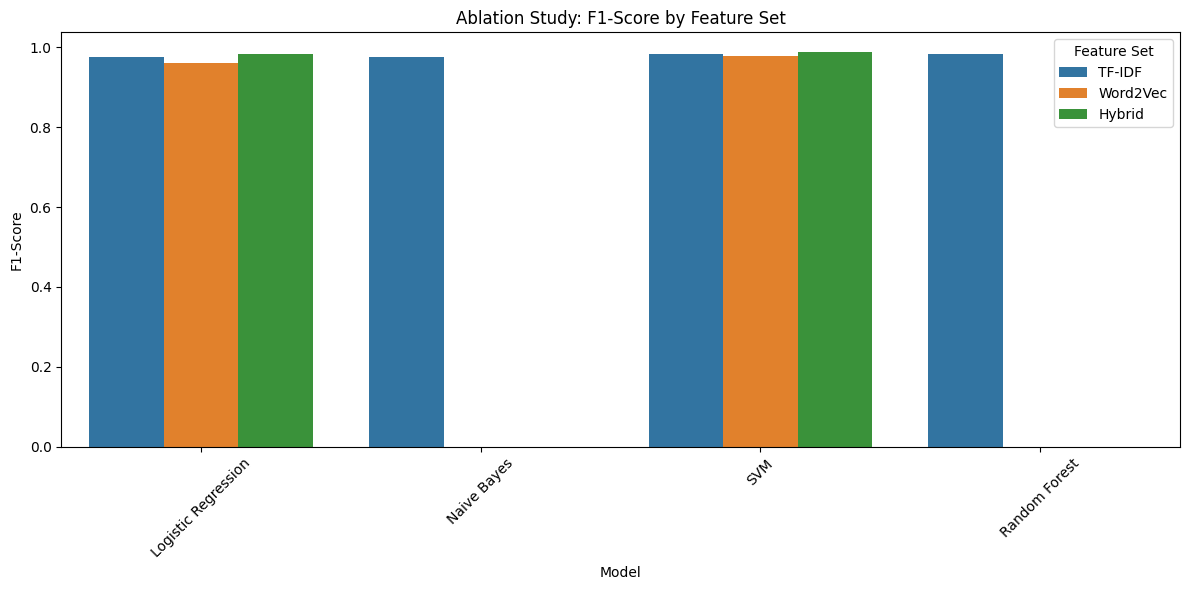

In [7]:
# Ablation study
ablation_results = {'Feature Set': [], 'Model': [], 'F1-Score': []}
feature_sets = {
    'TF-IDF': (X_train_tfidf, X_test_tfidf),
    'Word2Vec': (X_train_w2v, X_test_w2v),
    'Hybrid': (X_train_combined, X_test_combined)
}
for feat_name, (X_train_feat, X_test_feat) in feature_sets.items():
    for model_name, model in models.items():
        if model_name in ['Naive Bayes', 'Random Forest'] and feat_name in ['Word2Vec', 'Hybrid']:
            continue  # Skip incompatible combinations
        print(f"Training {model_name} with {feat_name} features...")
        model.fit(X_train_feat, y_train)
        y_pred = model.predict(X_test_feat)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        ablation_results['Feature Set'].append(feat_name)
        ablation_results['Model'].append(model_name)
        ablation_results['F1-Score'].append(f1)
ablation_df = pd.DataFrame(ablation_results)
ablation_df.to_csv('observations/ablation_study.csv', index=False)
print("\nAblation Study Results:")
print(ablation_df)
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1-Score', hue='Feature Set', data=ablation_df)
plt.title('Ablation Study: F1-Score by Feature Set')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('observations/ablation_study.png')
plt.show()

Training Logistic Regression...
Finished training Logistic Regression in 7.20 seconds

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3009
           1       0.98      0.98      0.98      2534

    accuracy                           0.98      5543
   macro avg       0.98      0.98      0.98      5543
weighted avg       0.98      0.98      0.98      5543



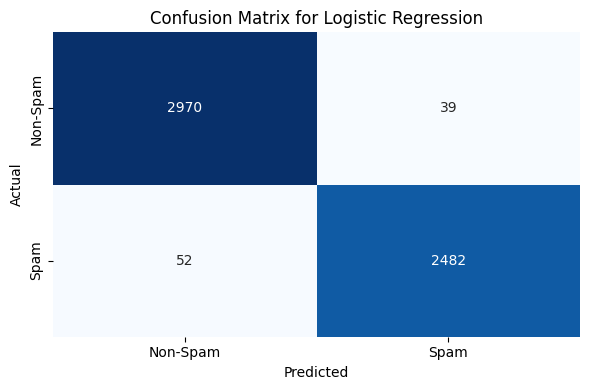

Training Naive Bayes...
Finished training Naive Bayes in 0.01 seconds

Classification Report for Naive Bayes:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3009
           1       0.97      0.98      0.98      2534

    accuracy                           0.98      5543
   macro avg       0.98      0.98      0.98      5543
weighted avg       0.98      0.98      0.98      5543



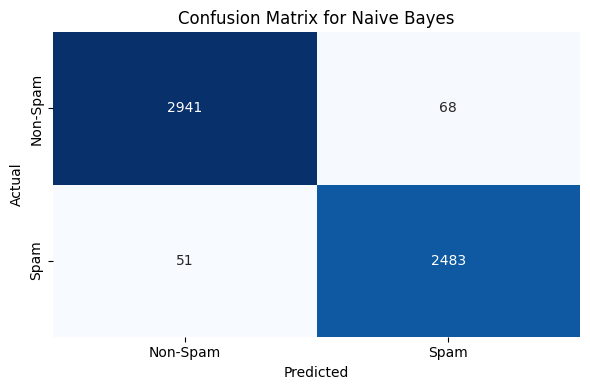

Training SVM...


In [ ]:
# Performance metrics
performance_metrics = {
    'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [],
    'F1-Score': [], 'ROC-AUC': [], 'CV F1-Score': [],
    'Training Time (s)': [], 'Inference Time (s)': []
}

# Train and evaluate
for model_name, model in models.items():
    # Select appropriate training and test data
    if model_name in ['Naive Bayes', 'Random Forest']:
        X_train_current = X_train_tfidf
        X_test_current = X_test_tfidf
    else:
        X_train_current = X_train_combined
        X_test_current = X_test_combined

    # Train with timing
    print(f"Training {model_name}...")
    start_time = time.time()
    model.fit(X_train_current, y_train)
    training_time = time.time() - start_time
    print(f"Finished training {model_name} in {training_time:.2f} seconds")
    
    # Predict
    start_time = time.time()
    y_pred = model.predict(X_test_current)
    inference_time = time.time() - start_time
    y_prob = model.predict_proba(X_test_current)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test_current)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_prob)
    cv_scores = cross_val_score(model, X_train_current, y_train, cv=3, scoring='f1', n_jobs=-1)
    
    # Store metrics
    performance_metrics['Model'].append(model_name)
    performance_metrics['Accuracy'].append(accuracy)
    performance_metrics['Precision'].append(precision)
    performance_metrics['Recall'].append(recall)
    performance_metrics['F1-Score'].append(f1)
    performance_metrics['ROC-AUC'].append(roc_auc)
    performance_metrics['CV F1-Score'].append(cv_scores.mean())
    performance_metrics['Training Time (s)'].append(training_time)
    performance_metrics['Inference Time (s)'].append(inference_time)
    
    # Classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Spam', 'Spam'], yticklabels=['Non-Spam', 'Spam'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'observations/confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
    plt.show()
    
    # Feature importance for Random Forest
    if model_name == 'Random Forest':
        rf_model = model.named_steps['classifier']
        importances = rf_model.feature_importances_
        feature_names = tfidf.get_feature_names_out()
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        importance_df = importance_df.sort_values('Importance', ascending=False).head(10)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df)
        plt.title('Top 10 Feature Importances for Random Forest')
        plt.tight_layout()
        plt.savefig('observations/rf_feature_importances.png')
        plt.show()

In [9]:
# Performance summary
performance_df = pd.DataFrame(performance_metrics)
print("\nPerformance Metrics Summary:")
print(performance_df)

# Save performance metrics to CSV for research report
performance_df.to_csv('observations/performance_metrics.csv', index=False)
print("\nPerformance metrics saved to 'observations/performance_metrics.csv'")


Performance Metrics Summary:
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  \
0  Logistic Regression  0.983583   0.984530  0.979479  0.981998  0.998144   
1          Naive Bayes  0.978531   0.973344  0.979874  0.976598  0.996002   
2                  SVM  0.988815   0.988538  0.986977  0.987757  0.998358   
3        Random Forest  0.984485   0.979248  0.986977  0.983097  0.997867   

   CV F1-Score  Training Time (s)  Inference Time (s)  
0     0.980813           7.043383            0.019529  
1     0.973948           0.010102            0.001824  
2     0.985588         961.971363           15.429181  
3     0.977953           0.881014            0.021494  

Performance metrics saved to 'performance_metrics.csv'


In [10]:
# Statistical tests
print("\nPairwise T-tests for F1-Scores:")
model_names = list(models.keys())
cv_f1_scores = {name: cross_val_score(model, X_train_tfidf if name in ['Naive Bayes', 'Random Forest'] else X_train_combined, y_train, cv=3, scoring='f1', n_jobs=-1) for name, model in models.items()}
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        m1, m2 = model_names[i], model_names[j]
        t_stat, p_value = ttest_rel(cv_f1_scores[m1], cv_f1_scores[m2])
        print(f"{m1} vs. {m2}: t={t_stat:.4f}, p={p_value:.4f}")


Pairwise T-tests for F1-Scores:
Logistic Regression vs. Naive Bayes: t=7.3787, p=0.0179
Logistic Regression vs. SVM: t=-24.2273, p=0.0017
Logistic Regression vs. Random Forest: t=14.1242, p=0.0050
Naive Bayes vs. SVM: t=-15.2215, p=0.0043
Naive Bayes vs. Random Forest: t=-4.2314, p=0.0516
SVM vs. Random Forest: t=22.3224, p=0.0020


In [ ]:
# Plot F1-scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1-Score', data=performance_df)
plt.title('Model Comparison based on F1-Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('observations/model_comparison_f1.png')
plt.show()

# Plot training times
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Training Time (s)', data=performance_df)
plt.title('Model Comparison based on Training Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('observations/model_comparison_training_time.png')
plt.show()

# Plot inference times
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Inference Time (s)', data=performance_df)
plt.title('Model Comparison based on Inference Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison_inference_time.png')
plt.show()

NameError: name 'plt' is not defined

In [12]:
# Save best model
best_model_name = performance_df.loc[performance_df['F1-Score'].idxmax(), 'Model']
best_model = models[best_model_name]
joblib.dump(best_model, 'best_spam_classifier.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(w2v_model, 'w2v_model.pkl')
print(f"\nBest model ({best_model_name}), TF-IDF vectorizer, scaler, and Word2Vec model saved.")


Best model (SVM), TF-IDF vectorizer, scaler, and Word2Vec model saved.
